## Image Colourisation

The program takes in two coloured image, reference image and target image. It converts the target image into a grayscale image, then transfers the colours from the reference image to the target image.

Paper referenced: https://ieeexplore.ieee.org/document/9164375

Dataset used: https://www.kaggle.com/datasets/gpiosenka/100-bird-species

In [1]:
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt
import os

## Pre-processing

The function <i>preprocess()</i> takes in 2 parameters, <i>reference</i> is a BGR image, <i>target</i> is a single channel grayscale image.
<ol>
    <li> Resize both images if they have different dimensions.
    <li> Convert and return both images as LAB colour space images.
</ol>

In [2]:
# reference = BGR image,   target = Single channel grayscale image
def preprocess(reference, target):
    # resize only if there's a difference is image size
    if (reference.shape[:2] != target.shape[:2]):
        # Get the shape of the images
        height1, width1, _ = reference.shape
        height2, width2 = target.shape

        # Get the maximum height and width
        max_height = max(height1, height2)
        max_width = max(width1, width2)

        # Resize the image using cv2.INTER_LINEAR to conserve the quality of the original images.
        reference = cv2.resize(reference, (max_width, max_height), interpolation=cv2.INTER_LINEAR)
        target = cv2.resize(target, (max_width, max_height), interpolation=cv2.INTER_LINEAR)
    
    # Convert GRAY --> BGR --> LAB 
    target = cv2.cvtColor(target, cv2.COLOR_GRAY2BGR)
    
    # reference = LAB reference image,   target = LAB target image
    return cv2.cvtColor(reference, cv2.COLOR_BGR2LAB), cv2.cvtColor(target, cv2.COLOR_BGR2LAB)

## Luminance Normalisation

The function <i>luminance_norm()</i> takes in 2 parameters, <i>reference</i> is a LAB image, <i>target</i> is a single channel LAB image.
<ol>
    <li> Find the standard deviation and mean of the luminance channel for both images.
    <li> Calculate the new luminance channel for the reference image.
    <li> Apply the new luminance channel to the reference image.
    <li> Return the normalised reference image.
</ol>

In [3]:
# reference = LAB reference image,   target = LAB target image
def luminance_norm(reference, target):
    # Getting the mean and standard deviation luminance of both image
    s_mean = np.mean(reference[...,0])
    s_std = np.std(reference[...,0])
    t_mean = np.mean(target[...,0])
    t_std = np.std(target[...,0])

    out = reference.copy()

    # applying normalisation on the luminance channel
    out[...,0] = np.clip((t_std/s_std) * (reference[...,0] - s_mean) + t_mean, 0, 255)
    
    # out = LAB normalise reference image
    return out

## Find the neighbourhood

The function <i>get_neighbours()</i> takes in 3 parameters, <i>img</i> is a single channel LAB image, <i>row</i> and <i>col</i> is the index of a pixel in <i>img></i>.
<ol>
    <li> Extract the dimensions of the image.
    <li> Create a x and y kernel in a range from -2 to 2.
    <li> Use the kernels to extract a 5x5 neighbourhood at img[row, col].
    <li> For areas outside of the bounds of img, set to 0.
    <li> Return a 5x5 kernel containing luminance values.
</ol>

In [4]:
# Gets a 5x5 neighbourhood for the pixel at img[row, col]
# img is a 1 channel image
def get_neighbours(img, row, col):
    # no of rows, no of cols
    height, width = img.shape[:2]
    
    # create a range(-2,3) on the x and y axis
    y,x = np.ogrid[-2:3, -2:3]

    # clip to avoid out of bounds array
    neighbours = img[np.clip(row+y, 0, height-1), np.clip(col+x, 0, width-1)]
    
    # for values out of bounds set to 0
    mask = (col+x > width-1) | (col+x < 0) | (row+y > height-1) | (row+y < 0)
    neighbours[mask] = 0
    
    return neighbours

## L2 Distance

The function <i>l2_distance()</i> takes in 2 parameters, <i>reference</i> is a LAB image, <i>target</i> is a single channel LAB image.
<ol>
    <li> Convert the images into a 1-dimensional list.
    <li> Initialize an empty 2-dimensional list to store the neighbourhood of each pixel.
    <li> Loops through the reference image 1-D list to find and store the neighbourhood of each pixel.
    <li> Loops through the target image 1-D list to find and store the neighbourhood of each pixel.
    <li> Find the smallest distance between each pixel in target image with each pixel in reference image.
    <li> Store and returns the indexes of the reference image in order that maps to target image.
</ol>

This part of the code is slow, takes around 8 minutes to complete a 224x224 image.

In [5]:
# ref_img is 3-channel a LAB colour space image
# target_img is a single channel LAB colour space image
def l2_distance(ref_img, target_img):
    # change the imgs to 1d
    ref = ref_img[..., 0].ravel()
    target = target_img.ravel()
    
    # Stores the 5x5 neighbourhood of each pixel in reference image
    ref_neighbours = np.empty((len(ref), 25))
    
    for i in range(len(ref)):
        row_r, col_r = np.unravel_index(i, ref_img[..., 0].shape)
        ref_neighbours[i] = get_neighbours(ref_img[..., 0], row_r, col_r).ravel()
    
    # Stores the indexes of the reference image that maps to the target image
    ref_indexes = np.empty(len(target), dtype=tuple)
    
    for i in range(len(target)):
        # Get the row, col based on the index of a 1D image
        row_t, col_t = np.unravel_index(i, target_img.shape)
        target_neighbours = get_neighbours(target_img, row_t, col_t).ravel()
        
        # Find the index of the minimum L2 distance between a single target neighbourhood
        # and all neighbourhoods in reference
        min_index = np.argmin(np.sum((ref_neighbours - target_neighbours)**2, axis=1))
        
        # Get the index (row, col) of the reference neighbourhood with the 
        # smallest distance
        row_r, col_r = np.unravel_index(min_index, ref_img[..., 0].shape)
        
        # Add to the list for output
        ref_indexes[i] = (row_r, col_r)
        
    return ref_indexes


## Colour Mapping

The function <i>map_color()</i> takes in 3 parameters, <i>ref_idx</i>, <i>ref_img</i> is a 3 channel LAB image, <i>target_img</i> is a single channel LAB image.
<ol>
    <li> Initialize 2 empty lists to store the A and B channels respectively.
    <li> Loops through the reference index from <i>l2_distance()</i>.
    <li> Retrive the A and B values using the reference image index.
    <li> Reshape the the A and B lists into a 2-D lists.
    <li> Merge the luminance channel from the target image with the A B lists to form a new LAB image.
    <li> Return the LAB image.
</ol>

In [6]:
# function to retrieve mapping of A and B values for target image
# ref_indexes is 1d array containing indexes for mapping towards target image based on reference image
# ref_img is 2d array containing L, a, b info from reference image
# target_img is 2d array containing luminance for target
def map_color(ref_idx, ref_img, target_img):
    h, w = target_img.shape[:2]

    # define empty 1d array for new A and B values for target image
    A = np.zeros(w*h).astype(int) 
    B = np.zeros(w*h).astype(int) 

    # for loop to iterate all pixels in the list
    for i in range(len(ref_idx)): 
        # mapping A and B values of reference image onto target image
        # Method 1: using array
        A[i] = ref_img[ref_idx[i]][1]
        B[i] = ref_img[ref_idx[i]][2]
        
        # Method 2: using saved text file
        # row = int(index_txt[i,0][1:])
        # col = int(index_txt[i,1][1:-1])
        # A[i] = ref[row, col][1]
        # B[i] = ref[row, col][2]
        
    # convert A and B into 2d array for next step of merging channels
    new_A = np.reshape(A, ((w, h))).astype(target_img.dtype)
    new_B = np.reshape(B, ((w, h))).astype(target_img.dtype)
        
    # merge three channels L, a, b to form the output image
    output_img = cv2.merge((target_img, new_A, new_B)) 

    return output_img

In [7]:
if __name__ == "__main__":
    timer = []
    bird_types = ["AFRICAN EMERALD CUCKOO", "AMERICAN FLAMINGO", "AZURE JAY", "CASSOWARY", "TOUCHAN"]
    # reference image number in dataset folder, 1 - 100
    ref_num = 1
    
    for bird_type in bird_types:
        bird1 = cv2.imread(f"dataset/Birds/{bird_type}/{str(i).zfill(ref_num)}.jpg")
        
        # Compares the reference image with the first 10 images in the dataset folder
        for i in range(1,11):
            tic = time.perf_counter()

            bird2 = cv2.imread(f"dataset/Birds/{bird_type}/{str(i).zfill(3)}.jpg", cv2.IMREAD_GRAYSCALE)

            reference, target = preprocess(bird1, bird2)
            out = luminance_norm(reference, target)

            ref_indexes = l2_distance(out, target[..., 0])
            map_img_lab = map_color(ref_indexes, out, target[..., 0])
            map_img_bgr = cv2.cvtColor(map_img_lab, cv2.COLOR_LAB2BGR)

            # Output the mapped colour image to out_img folder
            cv2.imwrite(f"out_img/Birds/{bird_type}/1_{i}.jpg", map_img_bgr)

            toc = time.perf_counter()
            timer.append((toc - tic)/60)
        
        
print("Average time: ", sum(timer)/len(timer))

Average time:  8.442210756300003


## Displaying Results

Display the image along with its coloured/grayscale histogram.

In [12]:
# function to display image without axis ticks
def showSubplotImage(img, title="" ):
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  
    plt.title(title)


# function to construct colour distribution lineplot
def colorDist(img):
    color = ('r','g','b')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plot = plt.plot(histr,color = col), plt.xlim([0,256])
    
    return histr


# function to construct a gray histogram
def grayHistogram(img, titlestr="", binsize=128):
    # build a gray histogram
    gray_hist, gray_bin = np.histogram(img, binsize, density=True)
    pos = np.arange(binsize)
    plot = plt.bar(pos, gray_hist, color='orange'), plt.title(titlestr), plt.yticks([])  

    return gray_hist

# function to display comparison of image colourisation
# speciesName = retrieve the bird species to compare
# ref_num = the reference image numbere, tested on 1 and 5 so far
def compareBirds(speciesName, ref_num):
    # path = retrieve path of current directory
    path = os.getcwd()
    
    # ref = the reference image used to obtain colour information, the first image for every species
    ref = cv2.imread(f"{path}/dataset/Birds/{speciesName}/{str(ref_num).zfill(3)}.jpg")
    ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)

    # for loop to go thhrough each family of target image
    for i in range(1, 11):
        # target = a grayscale image in which colourisation is to be applied
        # output = an RGB image which displays the target after colourisation
        # ori = target image with its original colours
        
        target = cv2.imread(f"{path}/dataset/Birds/{speciesName}/{str(i).zfill(3)}.jpg", cv2.IMREAD_GRAYSCALE)
        output = cv2.imread(f"{path}/out_img/Birds/{speciesName}/{ref_num}_{str(i)}.jpg")
        output  = cv2.cvtColor(output , cv2.COLOR_BGR2RGB)
        ori = cv2.imread(f"{path}/dataset/Birds/{speciesName}/{str(ref_num).zfill(3)}.jpg")
        ori  = cv2.cvtColor(ori , cv2.COLOR_BGR2RGB)

        # display subplots for images and colour histogram of selected bird species
        plt.figure(figsize=(25, 25), facecolor='white')
        
        imgs = [ref, target, output, ori]
        titles = ["Reference Image", "Target Image", "Output Image", "Target Image with Original Colours"]
        
        for i, (img, title) in enumerate(zip(imgs, titles)):
            plt.subplot(1, 4, i + 1)
            showSubplotImage(img, title)
        plt.show()
        
        plt.figure(figsize=(25, 3), facecolor='white')
        plt.subplot(141), colorDist(ref)
        plt.subplot(142), grayHistogram(target)
        plt.subplot(143), colorDist(output)
        plt.subplot(144), colorDist(ori)

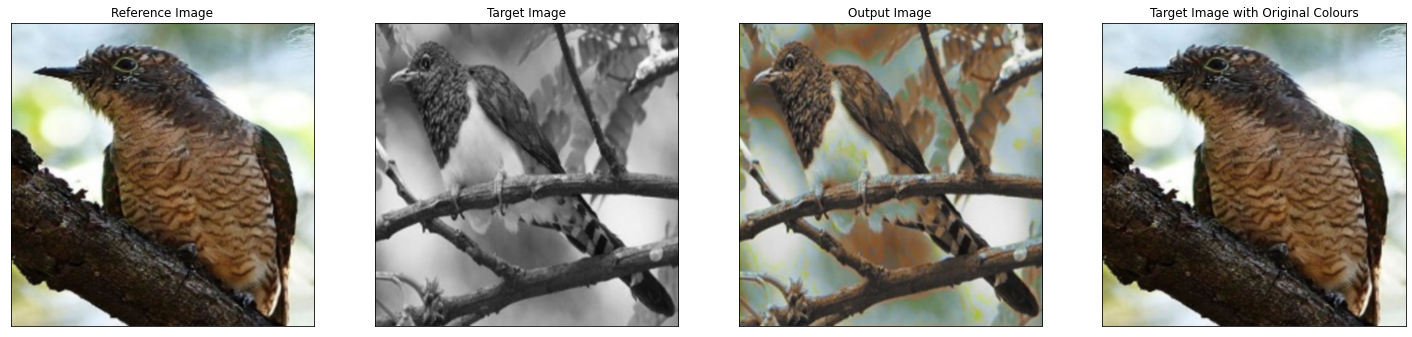

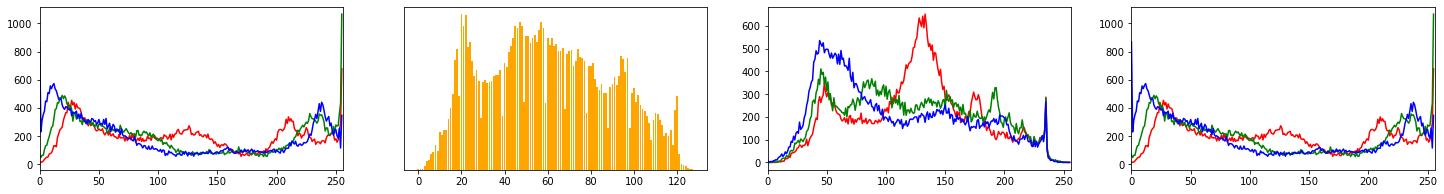

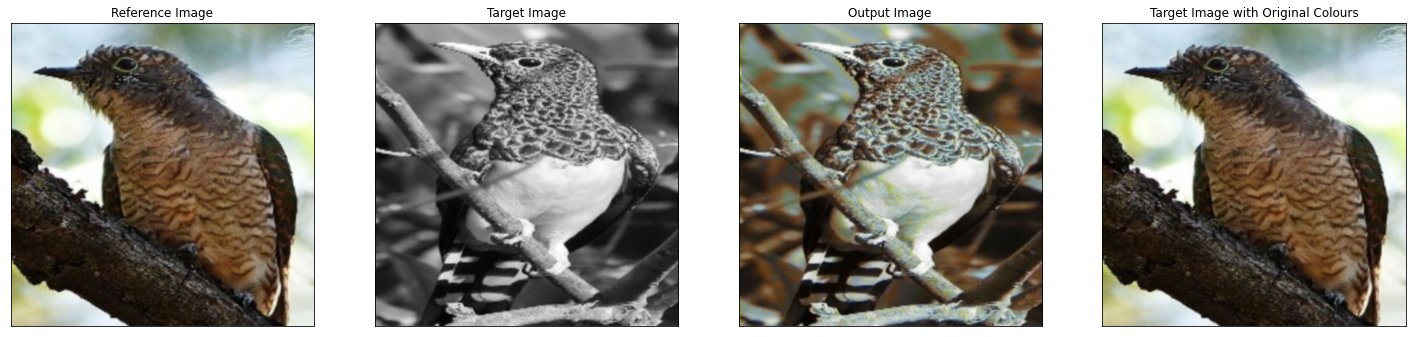

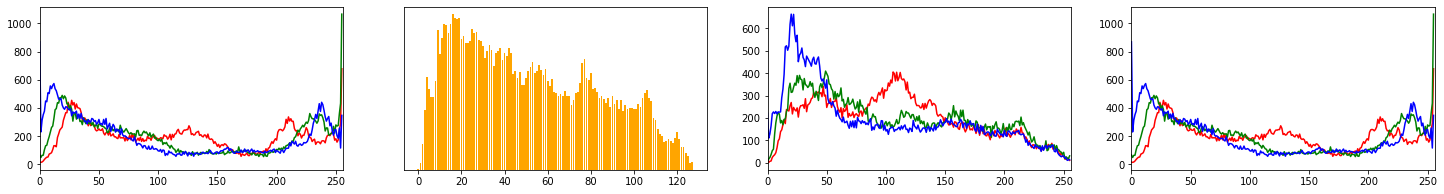

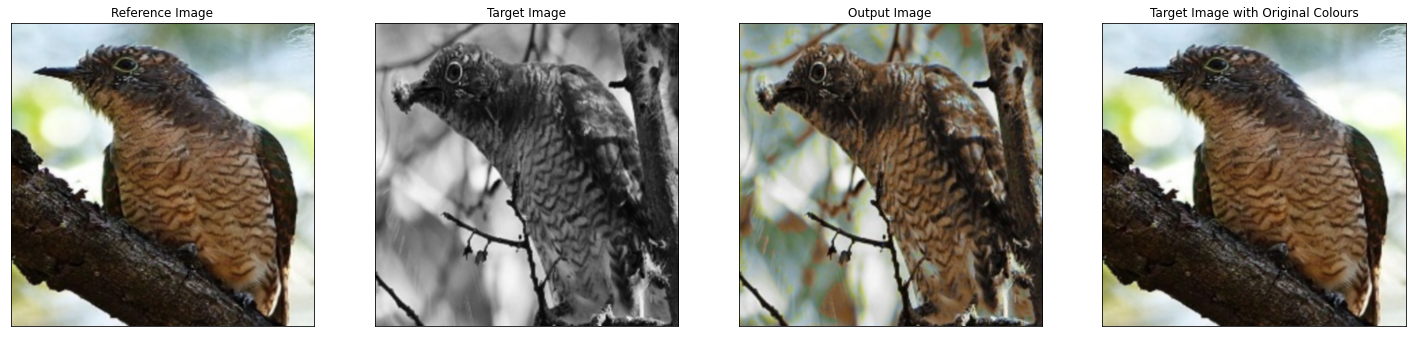

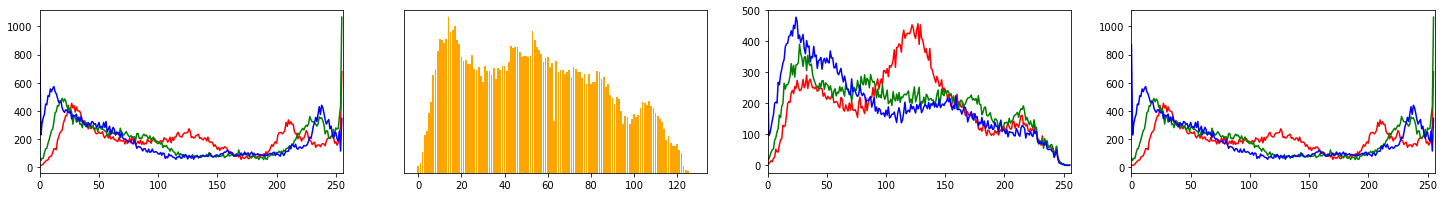

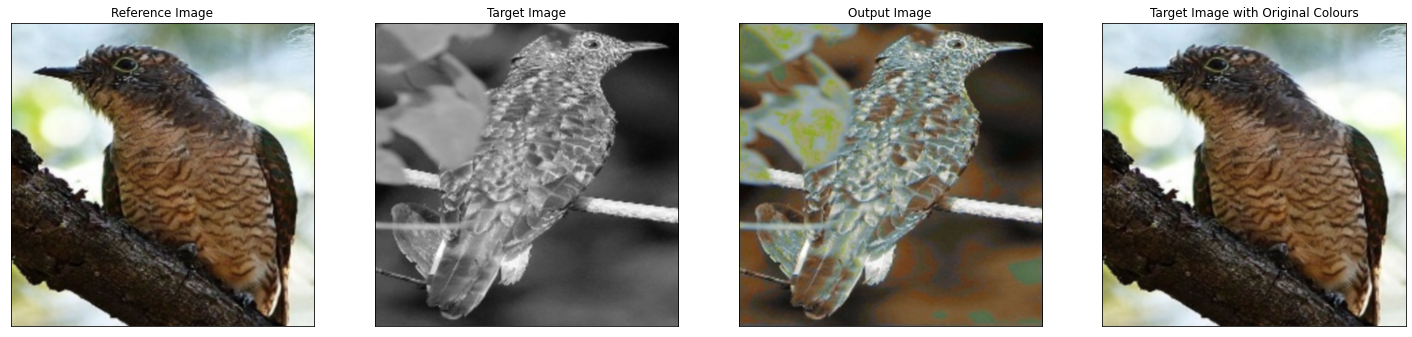

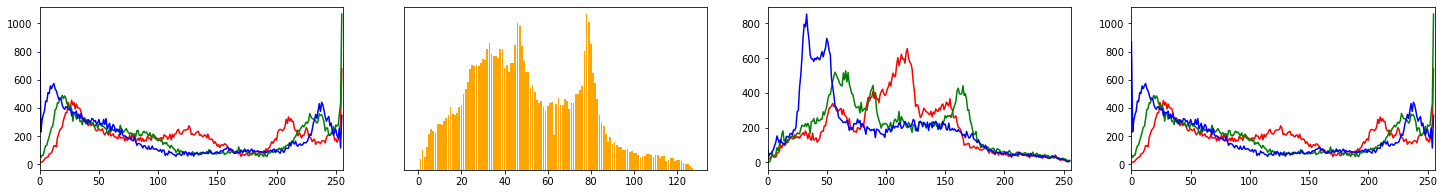

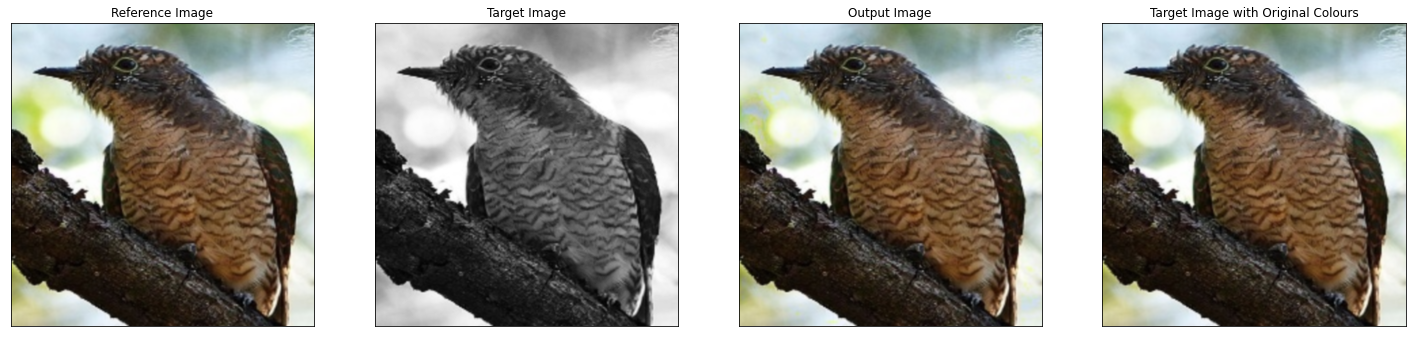

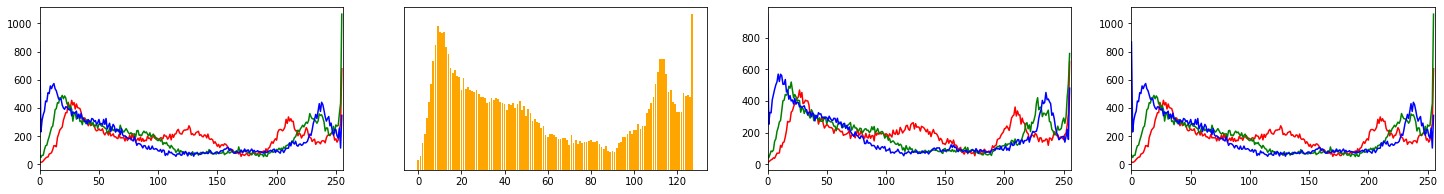

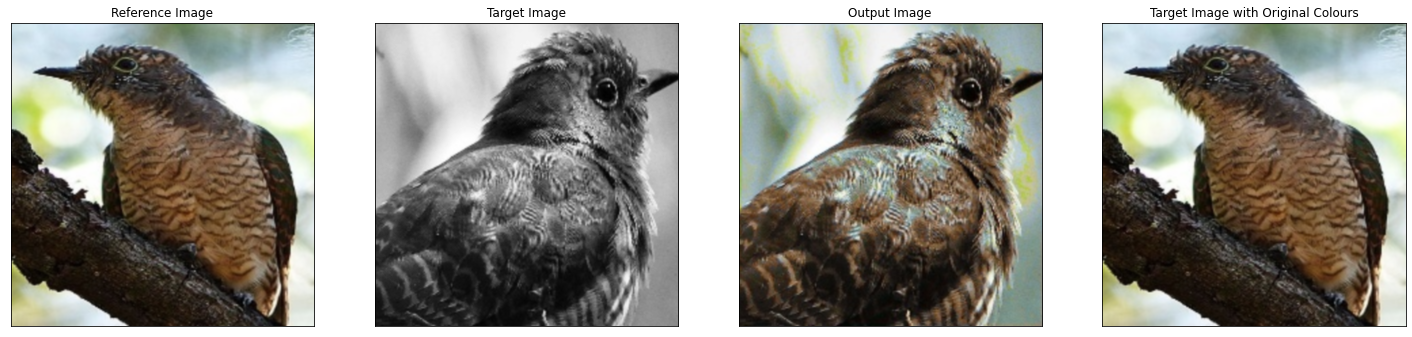

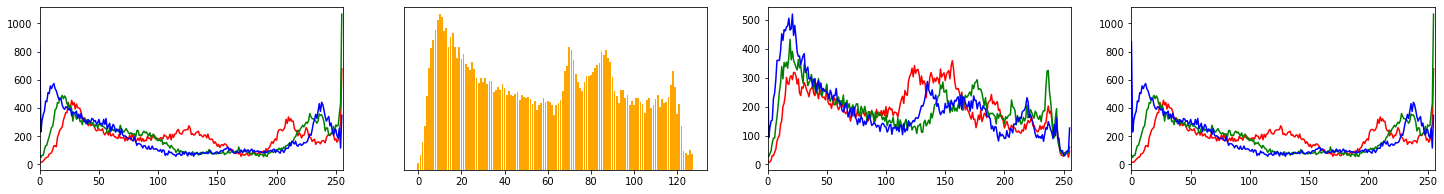

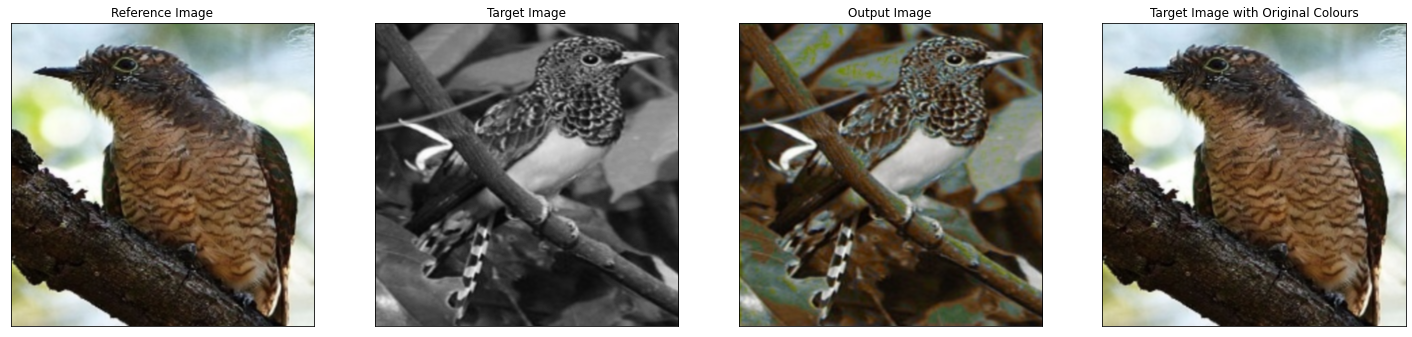

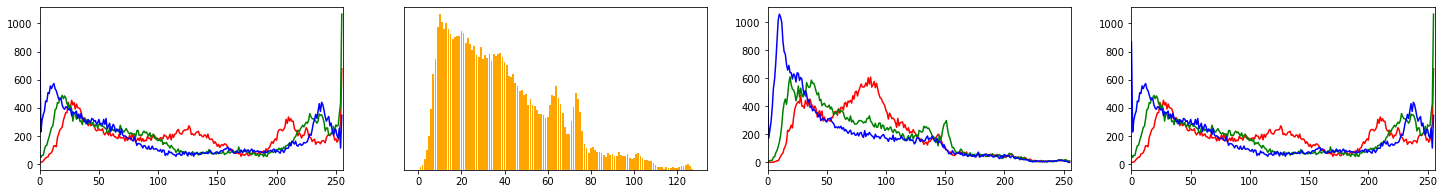

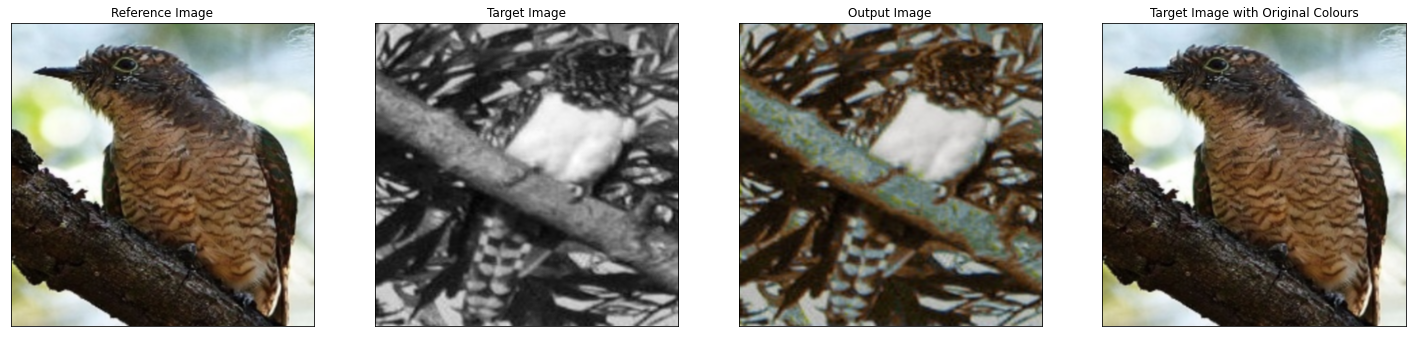

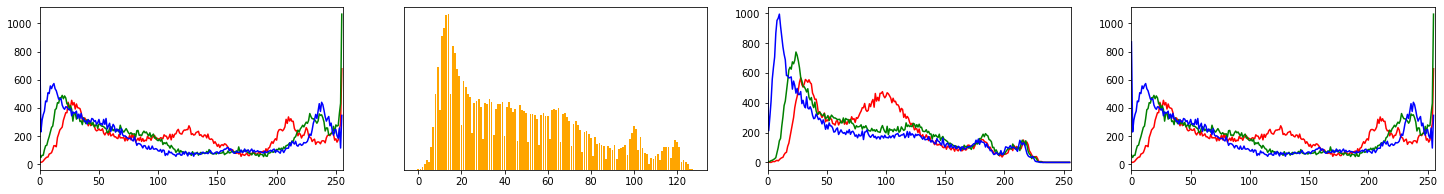

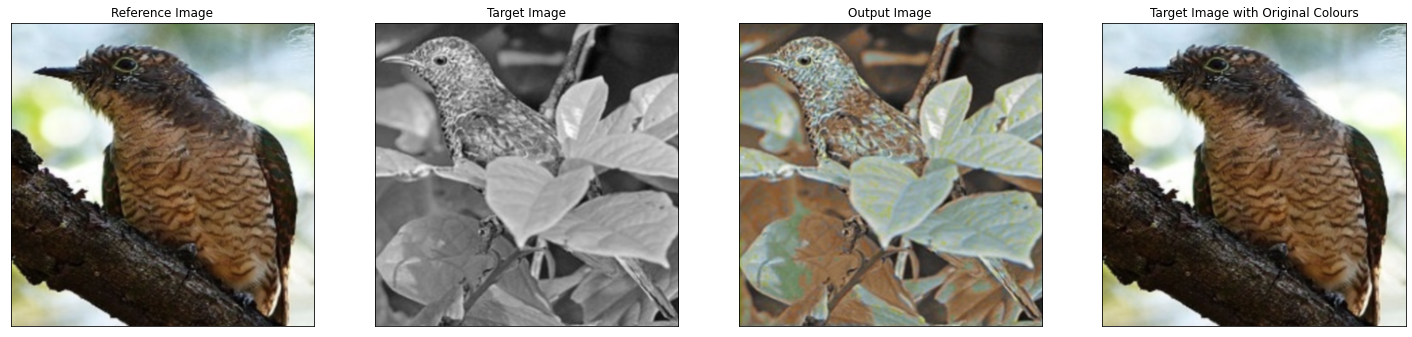

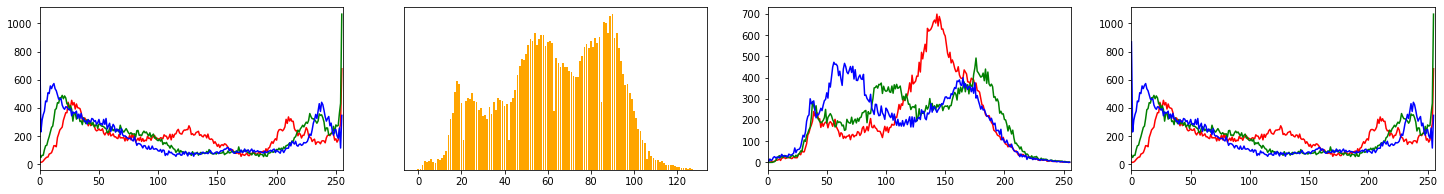

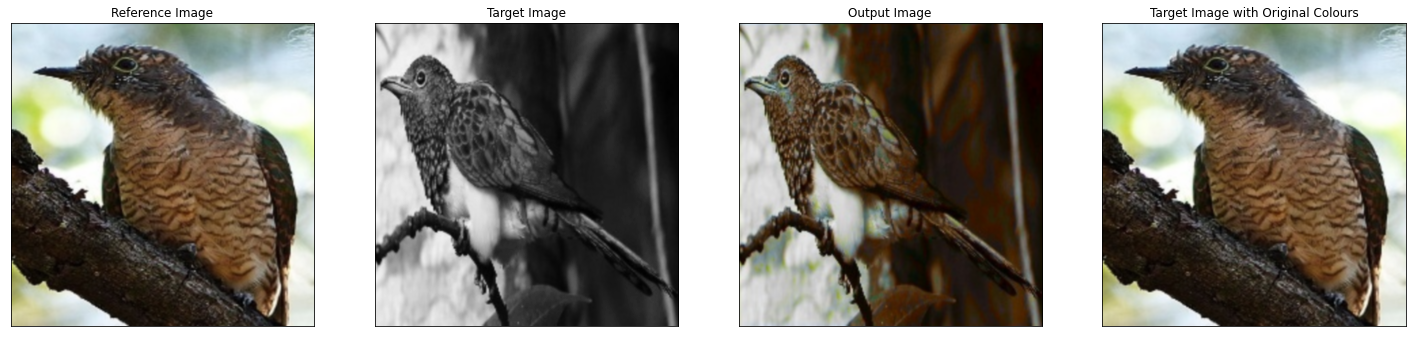

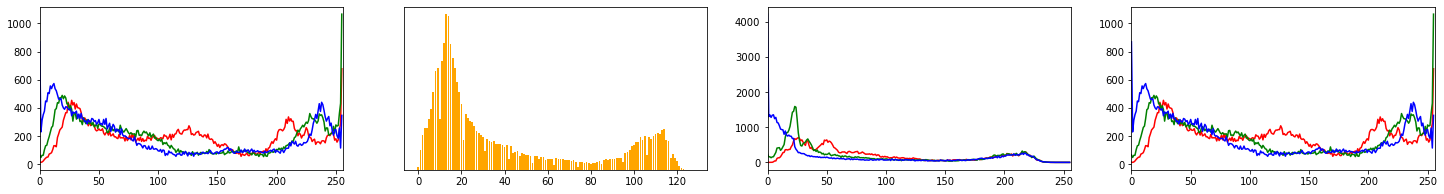

In [14]:
# bird_types = AFRICAN EMERALD CUCKOO, AMERICAN FLAMINGO, AZURE JAY, CASSOWARY, TOUCHAN
compareBirds("AFRICAN EMERALD CUCKOO", 5)